In [2]:
import fenics as fe
from fenics import *
from dolfin import *
from mshr import *
import matplotlib.pyplot as plt
from mshr import Polygon, generate_mesh

In [3]:
mu = Constant(1.0)  # Replace with your value for thermal diffusivity
sigma = Constant(5.67e-8)  # Replace with your value for the Stefan-Boltzmann constant
u_f = Constant(300.0)  # Replace with the external field temperature in Kelvin
u_fire = Constant(500.0)  # Replace with the fireplace temperature in Kelvin

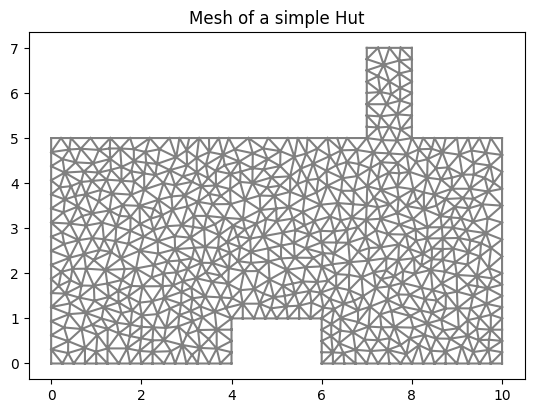

In [5]:
# Create empty Mesh 
mesh = Mesh()

# Create list of polygonal domain vertices
domain_vertices = [
    Point(0.0, 0.0), # edge of house
    Point(4.0, 0.0), # edge fireplace
    Point(4.0, 1.0), # edge fireplace
    Point(6.0, 1.0), # edge fireplace
    Point(6.0, 0.0), # edge fireplace
    Point(10.0, 0.0), # edge of house
    Point(10.0, 1.0), # edge window
    Point(10.0, 2.0), # edge window
    Point(10.0, 5.0), # edge of house
    Point(8.0, 5.0), # edge chimney
    Point(8.0, 7.0), # edge chimney
    Point(7.0, 7.0), # edge chimney
    Point(7.0, 5.0), # edge chimney
    Point(0.0, 5.0), # edge of house
]

domain = Polygon(domain_vertices)
mesh = generate_mesh(domain, 20)
plot(mesh)
plt.title("Mesh of a simple Hut")
plt.show()

In [6]:
# Initialize mesh function for interior domains
domains = MeshFunction("size_t", mesh, mesh.topology().dim())  # CellFunction
domains.set_all(0)

# Define new measures associated with the interior domains
dx = Measure("dx", domain=mesh, subdomain_data=domains)

# Define the boundaries
wall_thick = 1e-7 # 0.5
roof_thick = 1e-7 # 0.8
chimney_thick = 1e-7 # 0.2
floor_thick = 1e-7 # 0.5
window_thick = 1e-7 # 0.06
fireplace_thick = 1e-7 # 0.10

class Wall(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (
            near(x[0], 0)
            or (near(x[0], 10) and x[1] <= 1)
            or (near(x[0], 10) and x[1] >= 2)
        )

class Roof(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (
            (near(x[1], 5) and x[0] <= 7) or (near(x[1], 5) and x[0] >= 8)
        )

class Chimney(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (
            (near(x[0], 7) and x[1] >= 5)
            or (near(x[0], 8) and x[1] >= 5)
            or (near(x[1], 7))
        )

class Floor(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], 0) and (x[0] <= 4 or x[0] >= 6)

class Window(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (near(x[0], 10) and between(x[1], (1, 3.5)))

class Fire(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (near(x[1], 1) and between(x[0], (4, 6)))

class Brick(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (near(x[0], 4) and x[1] <= 1) or (near(x[0], 6) and x[1] <= 1)

class Obstacle(SubDomain):
    def inside(self, x, on_boundary):
        return between(x[1], (0.5, 0.7)) and between(x[0], (0.2, 1.0))


# create a cell function over the boundaries edges
sub_boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1) # mesh.topology().dim()-1
# set marker to 6
sub_boundaries.set_all(0)

wall = Wall()
wall.mark(sub_boundaries, 1)

roof = Roof()
roof.mark(sub_boundaries, 2)

chimney = Chimney()
chimney.mark(sub_boundaries, 3)

floor = Floor()
floor.mark(sub_boundaries, 4)

window = Window()
window.mark(sub_boundaries, 5)

fire = Fire()
fire.mark(sub_boundaries, 6)

brick = Brick()
brick.mark(sub_boundaries, 7)

# redefining integrals over boundaries
ds = Measure('ds', domain=mesh, subdomain_data=sub_boundaries)

In [12]:
# Neumann condition for Γflux
g_flux = Expression('mu * uf', mu=mu, uf=u_f, degree=2)
# Neumann condition for Γfire
g_fire = Expression('mu * sigma * (pow(u, 4) - pow(u_fire, 4))',
                    mu=mu, sigma=sigma, u=u_f, u_fire=u_fire, degree=2)

In [13]:
# Define function space
V = FunctionSpace(mesh, 'P', 1)
# Now, we define the variational problem
u = TrialFunction(V)
v = TestFunction(V)
a = mu * dot(grad(u), grad(v)) * dx
L = g_flux * v * ds(1) + g_fire * v * ds(2)

In [14]:
# Initial condition
u_n = interpolate(Constant(3.0), V)  # Initial temperature uniformly at 3 degrees Celsius
u = Function(V)
solve(a == L, u)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving linear variational problem.
